In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
elif torch.backends.mps.is_available():
    dev = "mps"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='mps')

In [3]:
# Standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

VOCSegmentation returns SegmentationClass masks. That means each pixel is labeled with a class ID (e.g., car, person), not a unique instance. It’s for semantic segmentation, not instance segmentation.

The target masks are loaded from the directory VOC2012/SegmentationClass/.
These are RGB .png files where each unique color represents a class (e.g., [128, 0, 0] for "aeroplane") and background is [0, 0, 0]. There is no separation between different objects of the same class.

In [4]:
def get_voc_dataloaders(batch_size=4):
    input_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])
    target_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.PILToTensor(),
    ])

    train_set = torchvision.datasets.VOCSegmentation(
        root='.', year='2012', image_set='train', download=True,
        transform=input_transform, target_transform=target_transform
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    return train_loader

In [5]:
# class FCN(nn.Module):
#     def __init__(self, num_classes):
#         super(FCN, self).__init__()
#         vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
#         features = list(vgg.features.children())

#         self.features = nn.Sequential(*features)
#         self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
#         self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

#     def forward(self, x):
#         x_size = x.size()
#         x = self.features(x)
#         x = self.score_fr(x)
#         x = self.upscore(x)
#         x = x[:, :, :x_size[2], :x_size[3]].contiguous()  # crop to match input size
#         return x

# model = FCN(num_classes=21).to(device)  # 21 classes in PASCAL VOC (20 objects + background)

In [6]:
# use an ImageNet-pretrained ResNet-50 backbone, train segmentation head from scratch:
# model = fcn_resnet50(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, num_classes=21, aux_loss=True).to(device)

# use pretrained weights for segmentation head (along with pretrained ResNet-50 backbone):
model = fcn_resnet50(weights=torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT, num_classes=21, aux_loss=True).to(device)

In [7]:
criterion = nn.CrossEntropyLoss(ignore_index=255)  # VOC uses 255 as ignore index
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
train_loader = get_voc_dataloaders()

In [9]:
epochs = 20

model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model(imgs)

        # loss = criterion(outputs, masks)

        # fcn_resnet50 outputs a dictionary with 'out' and possibly 'aux'
        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            aux_loss = criterion(outputs['aux'], masks)
            loss += 0.4 * aux_loss  # typical weight for aux loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch += loss.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 259.7080
Epoch 2, Loss: 174.6973
Epoch 3, Loss: 134.7998
Epoch 4, Loss: 108.9813
Epoch 5, Loss: 91.2853
Epoch 6, Loss: 79.2199
Epoch 7, Loss: 57.7002
Epoch 8, Loss: 56.3759
Epoch 9, Loss: 61.7090
Epoch 10, Loss: 71.1378
Epoch 11, Loss: 60.1735
Epoch 12, Loss: 39.4548
Epoch 13, Loss: 30.4313
Epoch 14, Loss: 24.6047
Epoch 15, Loss: 24.0322
Epoch 16, Loss: 75.5595
Epoch 17, Loss: 63.2316
Epoch 18, Loss: 38.2028
Epoch 19, Loss: 27.2755
Epoch 20, Loss: 17.1446


In [10]:
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [11]:
# VOC colormap for 21 classes
VOC_COLORMAP = np.array([
    (0, 0, 0),        # 0=background
    (128, 0, 0),      # 1=aeroplane
    (0, 128, 0),      # 2=bicycle
    (128, 128, 0),    # 3=bird
    (0, 0, 128),      # 4=boat
    (128, 0, 128),    # 5=bottle
    (0, 128, 128),    # 6=bus
    (128, 128, 128),  # 7=car
    (64, 0, 0),       # 8=cat
    (192, 0, 0),      # 9=chair
    (64, 128, 0),     # 10=cow
    (192, 128, 0),    # 11=dining table
    (64, 0, 128),     # 12=dog
    (192, 0, 128),    # 13=horse
    (64, 128, 128),   # 14=motorbike
    (192, 128, 128),  # 15=person
    (0, 64, 0),       # 16=potted plant
    (128, 64, 0),     # 17=sheep
    (0, 192, 0),      # 18=sofa
    (128, 192, 0),    # 19=train
    (0, 64, 128)      # 20=tv/monitor
], dtype=np.uint8)

In [12]:
def decode_segmap(mask):
    """
    Convert class indices to RGB using VOC colormap.
    Ignore index (255) is mapped to background (0) just for visualization.
    """
    mask = np.where(mask == 255, 0, mask)
    return VOC_COLORMAP[mask]

In [13]:
def visualize_masks(img_tensor, pred_mask, gt_mask=None):
    img_tensor = img_tensor.cpu() * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)
    original_img = img_tensor.permute(1, 2, 0).numpy()
    original_img = (original_img * 255).astype(np.uint8)
    mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()
    color_mask = decode_segmap(mask)

    fig, axs = plt.subplots(1, 3 if gt_mask is not None else 2, figsize=(18, 6))

    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(color_mask)
    axs[1].set_title("Prediction")
    axs[1].axis('off')

    if gt_mask is not None:
        gt_np = gt_mask.squeeze().cpu().numpy()
        gt_rgb = decode_segmap(gt_np)
        axs[2].imshow(gt_rgb)
        axs[2].set_title("Ground Truth")
        axs[2].axis('off')

    plt.tight_layout()
    plt.show()

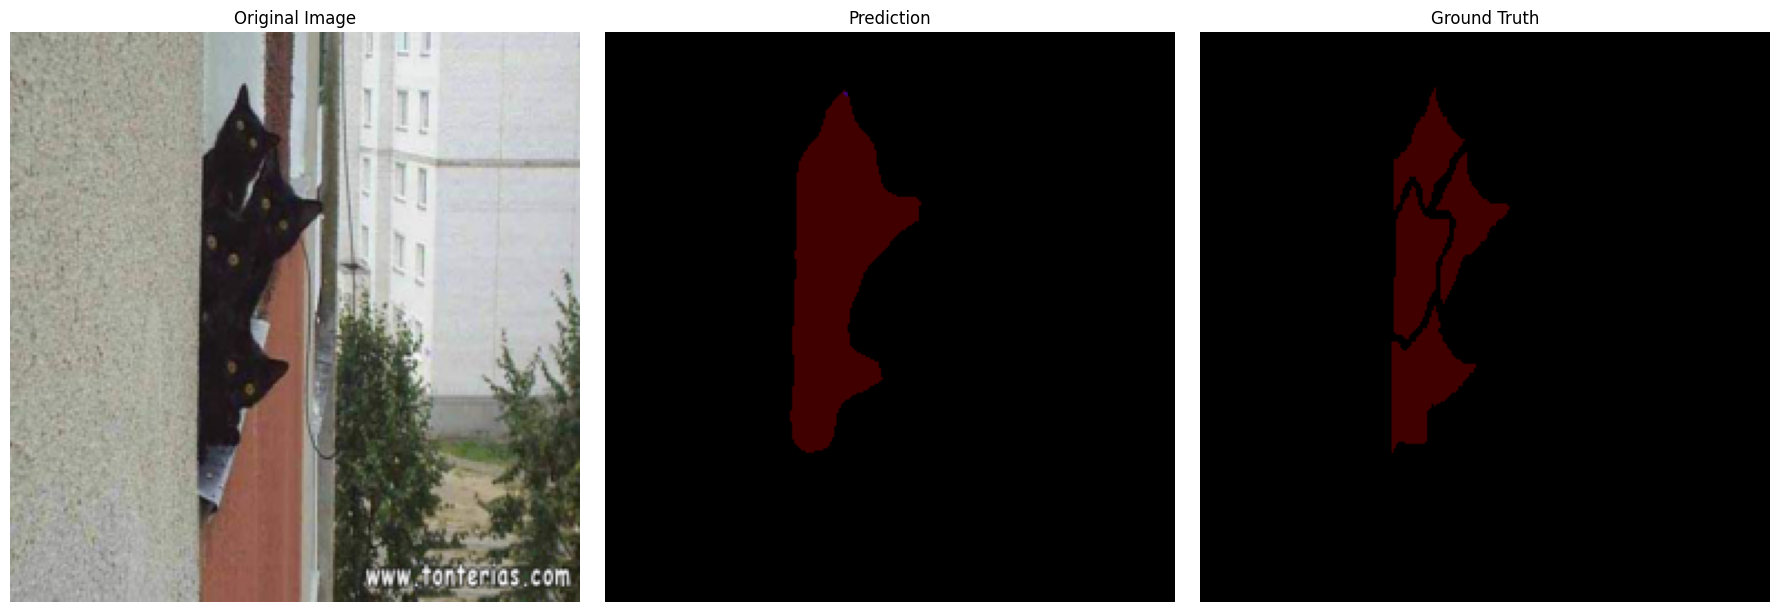

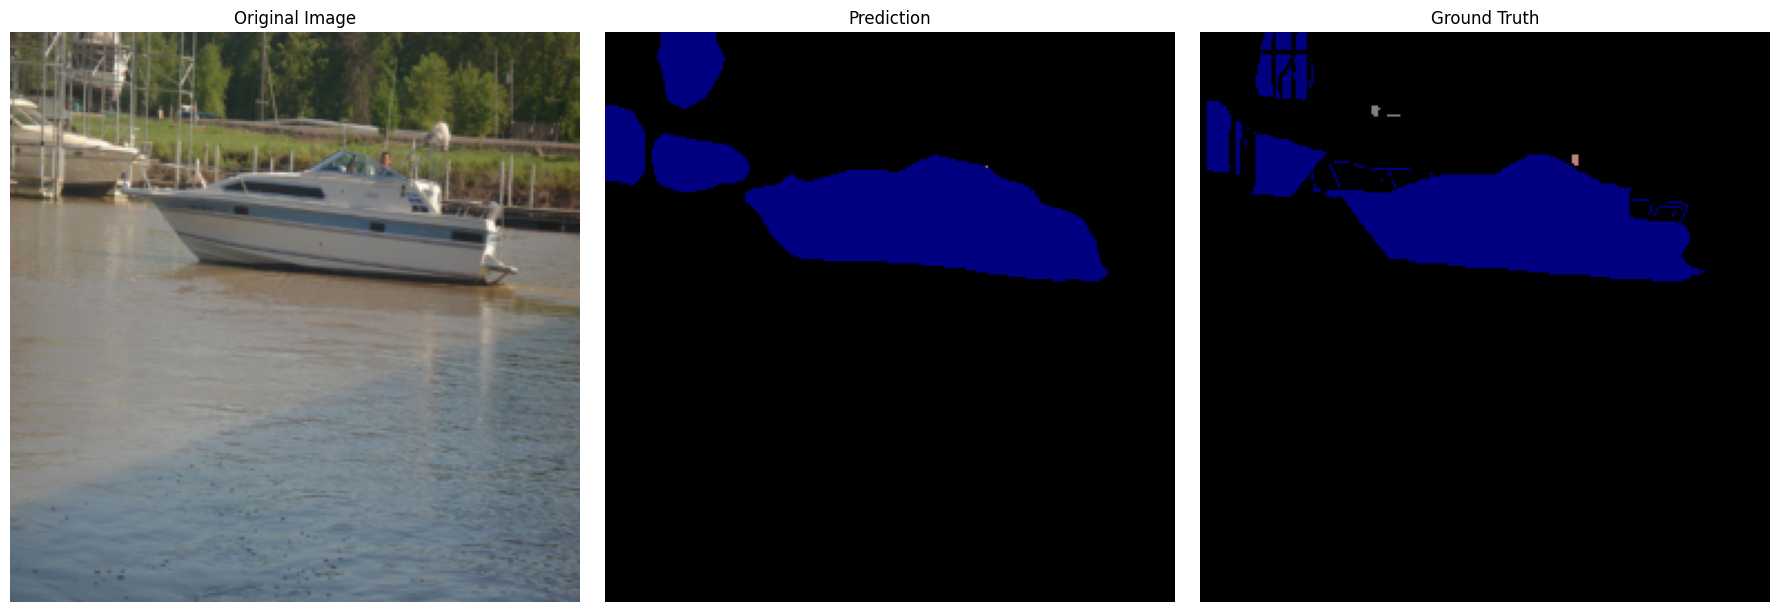

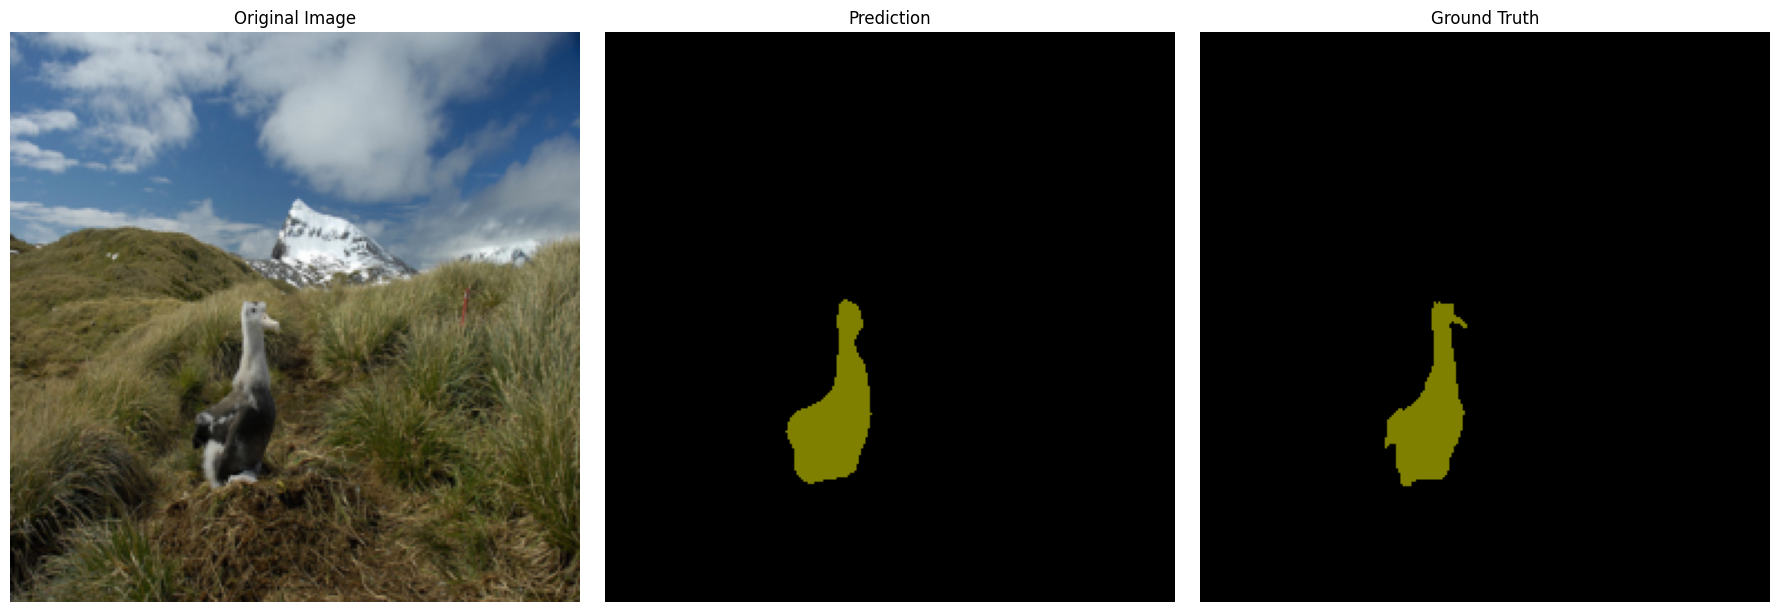

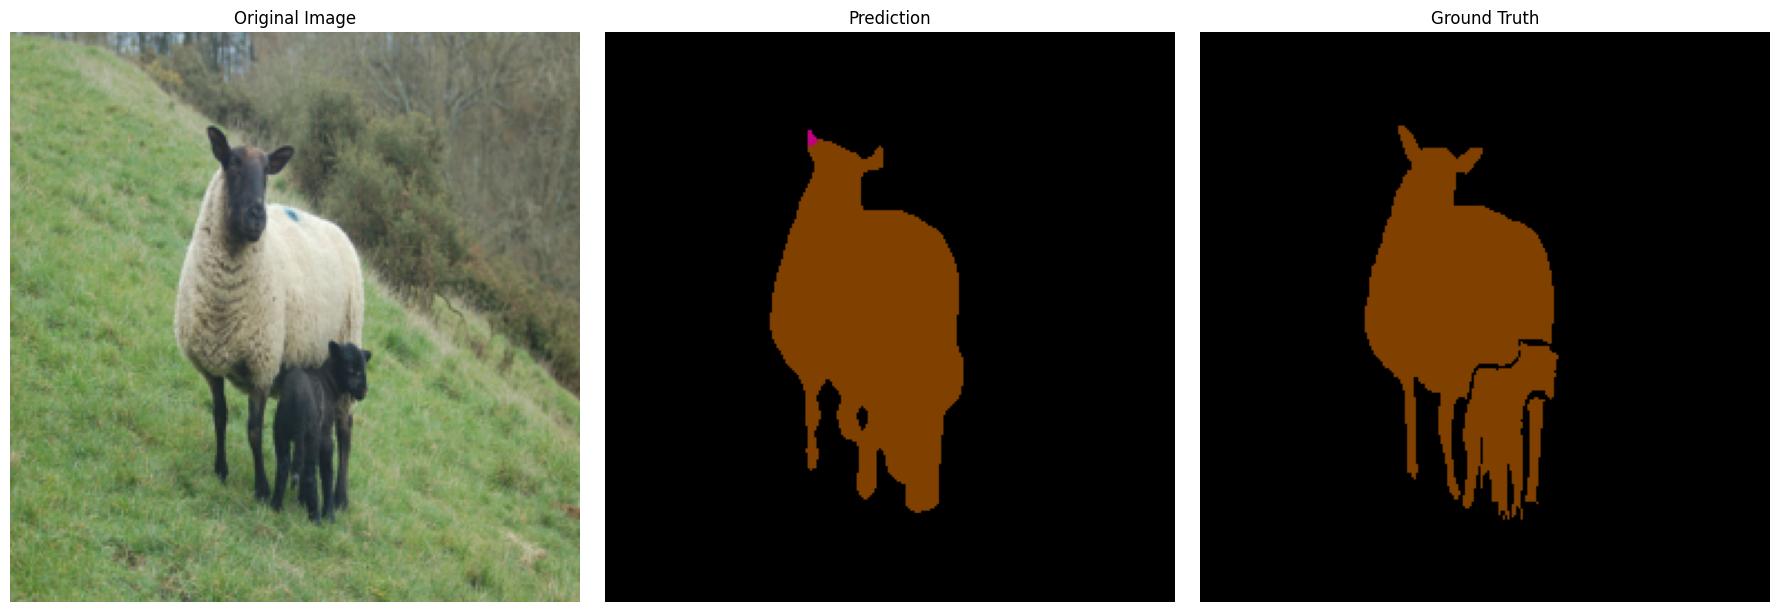

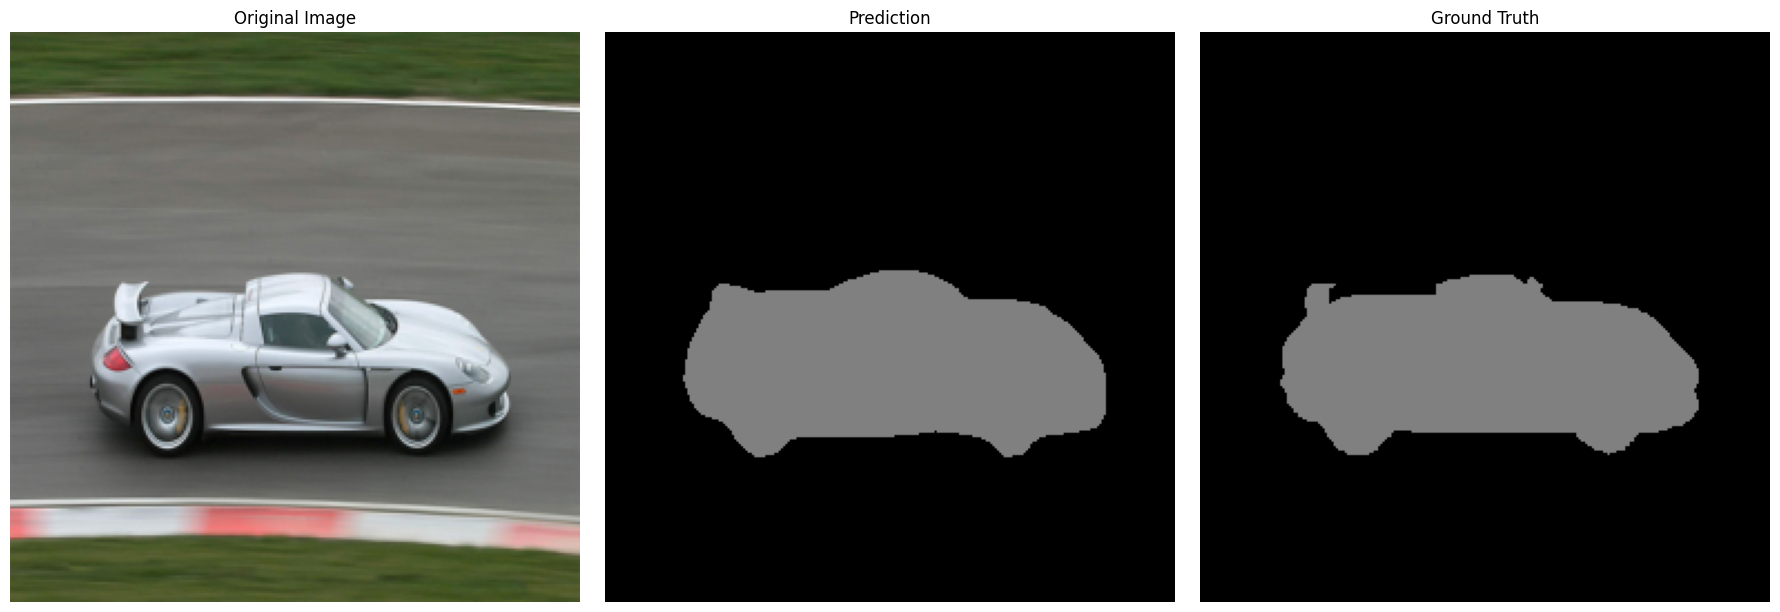

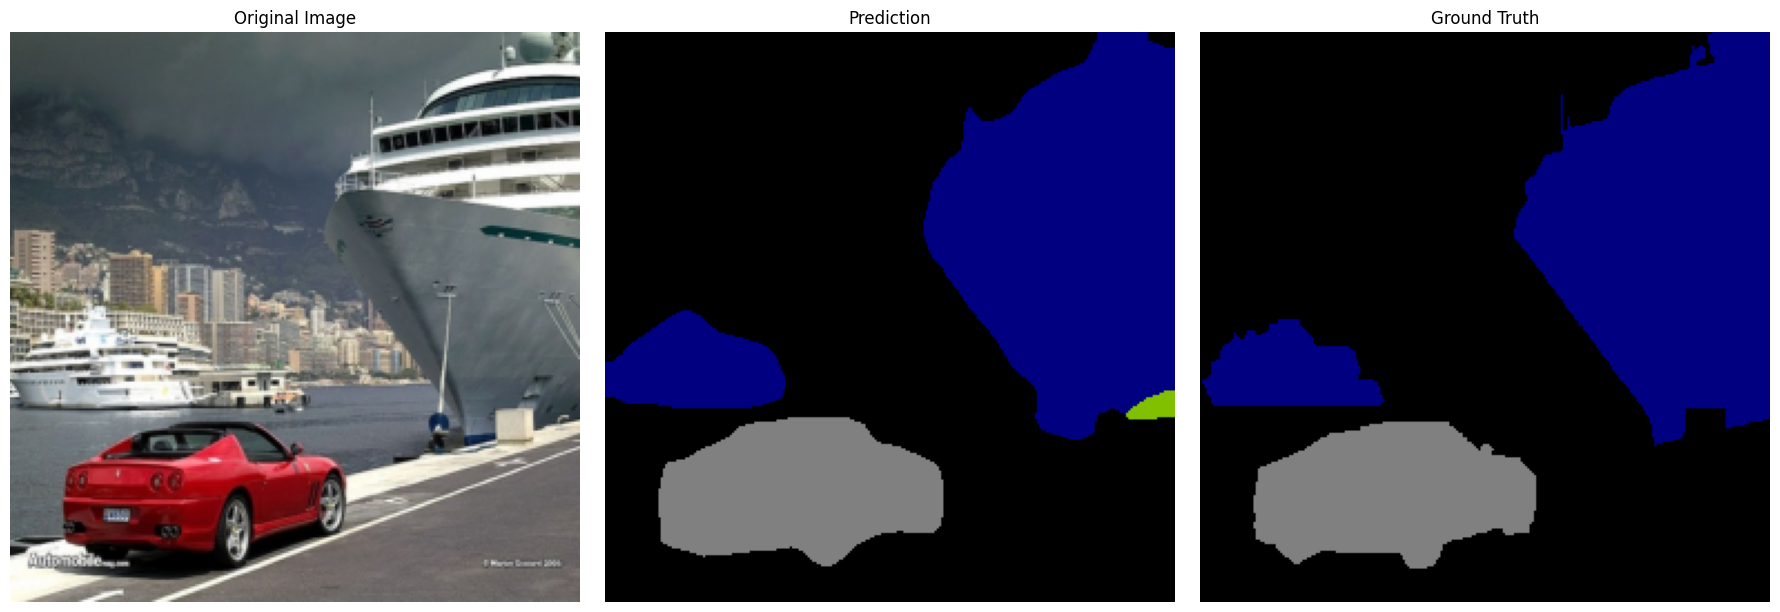

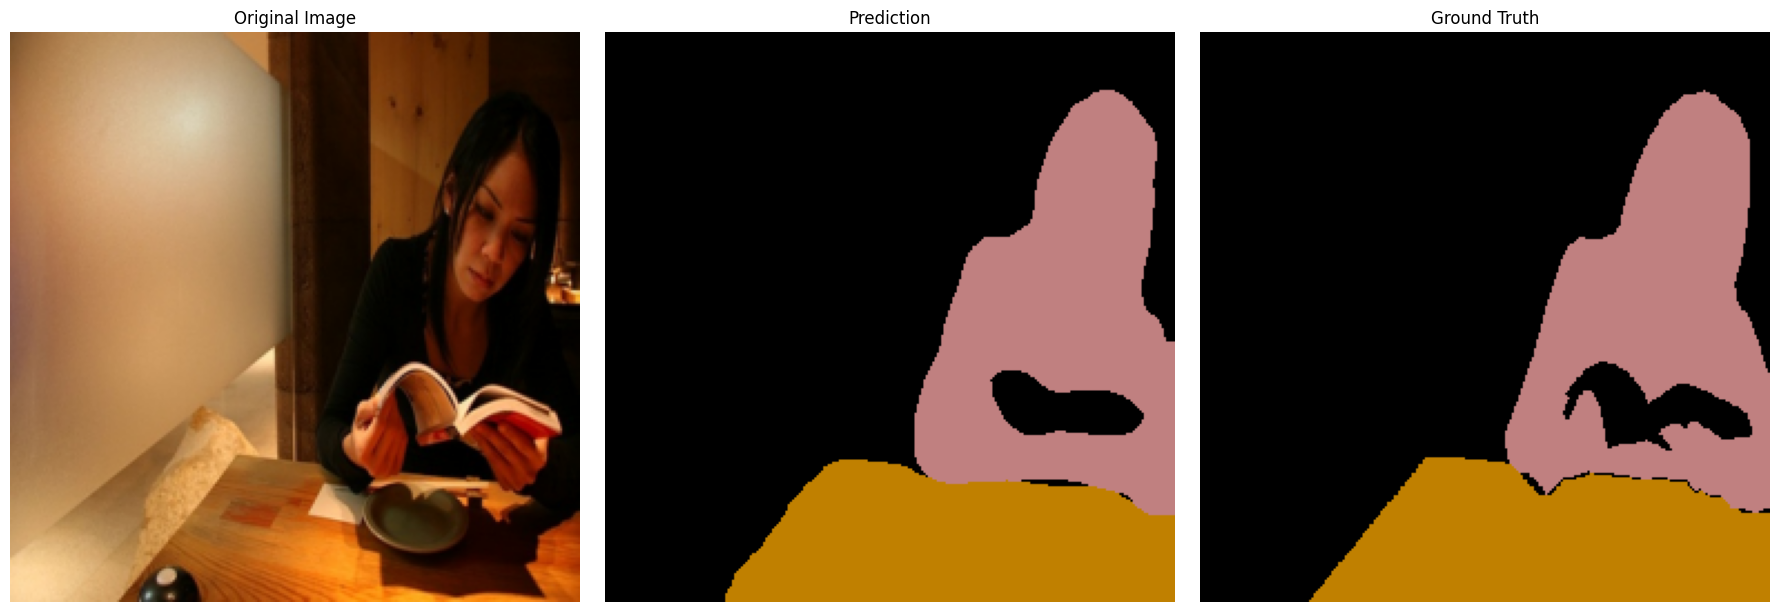

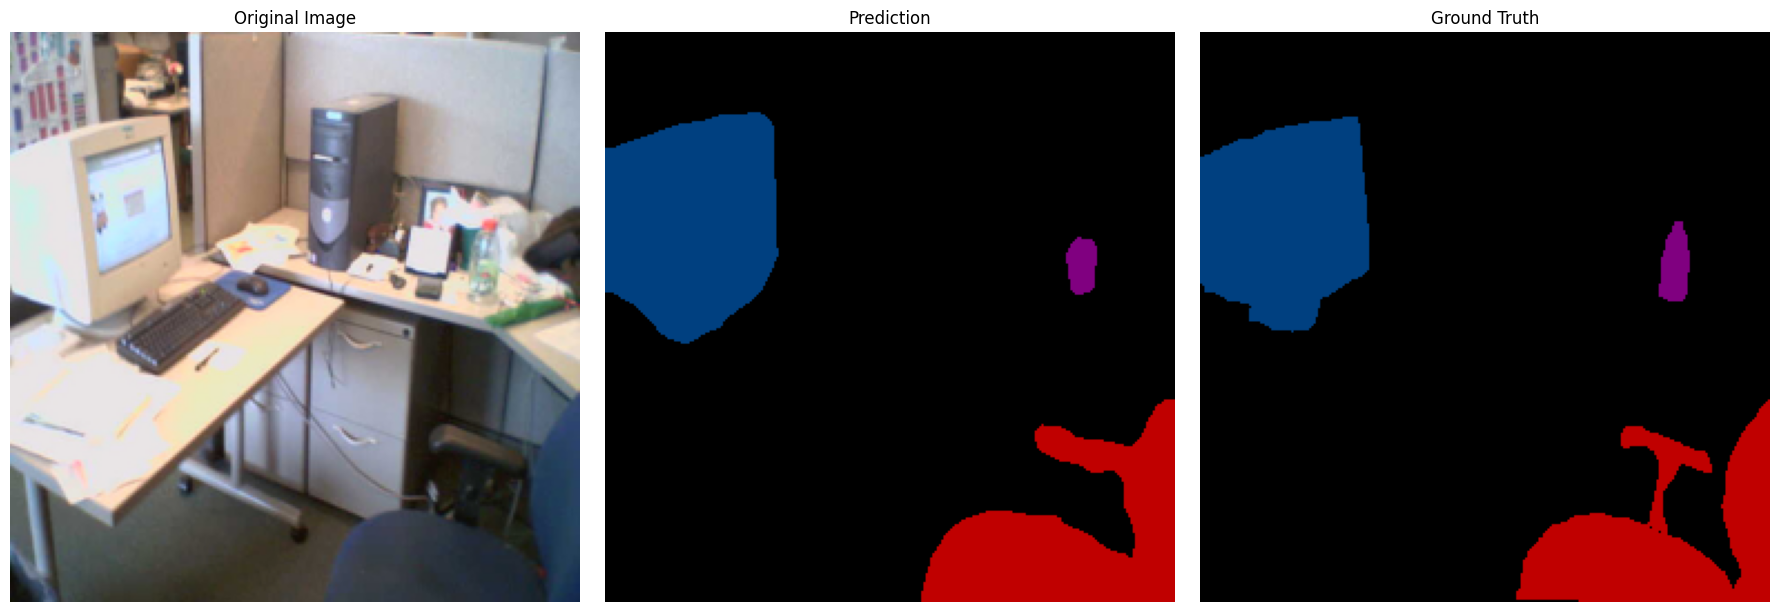

In [14]:
with torch.no_grad():
    for i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)['out']

        for j in range(min(4, imgs.size(0))):  # just a few samples
            visualize_masks(imgs[j], outputs[j].unsqueeze(0), masks[j])

        if i == 2:
            break  # visualize only a few examples